### Librerias Utiles

In [ ]:
import sys
import os

sys.path.append(os.path.abspath("../data-mining"))
sys.path.append(os.path.abspath("../data-preprocessing"))
sys.path.append(os.path.abspath("../data-retrieval"))

import pandas as pd
import ast
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from config import SessionLocal
from models.db_models import ProcessedArticle
from scripts.utils.common import load_config, get_embedder
from storage.data_loader import load_articles_from_db
from qdrant_client import QdrantClient, models

load_dotenv()
config = load_config()
client = QdrantClient(url=os.getenv("QDRANT_URL"), api_key=os.getenv("QDRANT_API_KEY"))


Obtener embbeders

In [28]:
def return_embedder(embedder_type):
    db = SessionLocal()
    articles = None
    try:
        articles = load_articles_from_db(
            db,
            use_processed=True,
            min_words=config['processing']['min_words'],
            max_words=config['processing']['max_words']
    ) if embedder_type in ['tfidf', 'bm25'] else None
    
    except Exception as e:
        print(f"Error loading articles: {e}")
        raise
    finally:
        db.close()

    embedder = get_embedder(embedder_type, config, articles)
    return embedder

In [46]:
embbeders_name = ['tfidf', 'bm25', 'dpr', 'sbert', 'minilm']
embbeders = [return_embedder(embbeder) for embbeder in embbeders_name]
for embbeder in embbeders:
    print(embbeder.dimension)


Fitting tfidf embedder on 500 articles...
Fitting bm25 embedder on 500 articles...


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


384
384
768
768
384


In [31]:
collections = {'news_tfidf': {'size': 384}, 
               'news_bm25': {'size': 384}, 
               'news_dpr': {'size': 768}, 
               'news_sbert': {'size': 768}, 
               'news_minilm': {'size': 384}}

Limpiar colecciones de ser necesario

In [ ]:
# for name, collection in collections.items():
#     print(client.delete_collection(collection_name=name))

True
True
True
True
True


#### Crear colecciones

In [34]:
for name, collection in collections.items():
    client.create_collection(
        collection_name=name,
        vectors_config=models.VectorParams(size=collection['size'], distance=models.Distance.COSINE),
    )

#### Insertar Vectores

In [44]:
def get_news() -> dict:
    """Retrieve all processed news from the database."""
    news = {}
    db = SessionLocal()
    try:
        processed_articles = db.query(ProcessedArticle).all()
        for article in processed_articles:
            news[article.article_id] = {'title' : article.processed_title, 'content': article.processed_content}
    except Exception as e:
        print(f"Error retrieving news: {e}")
        raise
    finally:
        db.close()

    return news

news = get_news()
# print primer new
print(news[1]['title'])

agosto cerrar superávit 99,6% pagar deuda dramático caída ingreso


In [48]:
for name, collection in collections.items():
    embbeder = embbeders[embbeders_name.index(name.split('_')[1])]
    print(f"Inserting news into {name} collection...")
    print(f"Embedding news with {embbeder}...")
    for new in news:
        client.upsert(
            collection_name=name,
            points=[
                models.PointStruct(
                    id=new,
                    payload={
                        "title": news[new]['title'],
                        "content": news[new]['content'],
                    },
                    vector=embbeder.embed(news[new]['content'])
                )
            ]
        )

Inserting news into news_tfidf collection...
Embedding news with <embedders.tfidf.TfidfEmbedder object at 0x0000021A7ED71220>...
Inserting news into news_bm25 collection...
Embedding news with <embedders.bm25.BM25Embedder object at 0x0000021A233FF890>...
Inserting news into news_dpr collection...
Embedding news with <embedders.dpr.DPREmbedder object at 0x0000021A24C3FAA0>...
Inserting news into news_sbert collection...
Embedding news with <embedders.sbert.SBERTEmbedder object at 0x0000021A24C3F740>...
Inserting news into news_minilm collection...
Embedding news with <embedders.minilm.MiniLMEmbedder object at 0x0000021A249DD0A0>...


#### Pruebas a mano

In [ ]:
embedder = return_embedder('tfidf')
query_vector = embedder.embed('¿Cuál fue el superávit fiscal reportado en agosto de 2024?')

resultados = client.search(
    collection_name='news_tfidf',
    query_vector=query_vector,
    limit=5
)
for i in range(5):
    print(resultados[i].payload['title'])


Fitting tfidf embedder on 500 articles...
agosto cerrar superávit 99,6% pagar deuda dramático caída ingreso
actividad pyme caer noveno mes consecutivo acumular baja 16,9% 2024
actividad industrial caer 10,8% interanual agosto
gobierno oficializar aumento jubilación ascender haber octubre
industria pyme caer 8,7% interanual agosto


### Preparación del test

In [55]:
def qdrant_search(prompt, embedder):
    query_vector = embedder.embed(prompt)
    results = client.search(
        collection_name=embedder.collection_name,
        query_vector=query_vector,
        limit=5
    )

    return results

In [59]:
def test_retrieval(num_rows=100):
    test_dataset = pd.read_csv('test_dataset.csv', encoding='utf-8')
    test_dataset['questions'] = test_dataset['questions'].apply(ast.literal_eval)

    if num_rows is not None:
        test_dataset = test_dataset.head(num_rows)
    
    results = {}

    for embedder in embbeders:
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        total_questions = 0

        for index, row in test_dataset.iterrows():
            print(f"\nDataset title: {row['new']}") 
            correct_title = row['new']
            for question in row['questions']:
                print(f"\nQuestion: {question}\n")
                response = qdrant_search(question, embedder)
                total_questions += 1

                # Variable para saber si encontramos el título correcto
                found_correct = False

                # Contador de resultados devueltos
                total_results = len(response)

                for res in response:
                    qdrant_title = res.payload['title']
                    print(f"Qdrant title: {qdrant_title}")
                    if qdrant_title == correct_title:
                        # Encontramos el correcto
                        found_correct = True

                if found_correct:
                    # Un verdadero positivo por el match correcto
                    true_positives += 1
                    # Todos los demás resultados no coinciden son falsos positivos
                    # Si hay N resultados y uno es correcto, N-1 son FP
                    false_positives += (total_results - 1)
                    print(f"MATCHED - TP:1, FP:{total_results - 1}")
                else:
                    # No encontramos el correcto: FN = 1, FP = total_results
                    false_negatives += 1
                    false_positives += total_results
                    print(f"NO MATCH - FN:1, FP:{total_results}")


        accuracy = true_positives / total_questions if total_questions > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


        results[embedder] = {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1_score': f1
        }

        print(f"Embedder: {embedder}")
        print(f"Accuracy: {accuracy}")
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")
        print(f"F1 Score: {f1}")

    return results

In [60]:
results = test_retrieval()


Dataset title: agosto cerrar superávit 99,6% pagar deuda dramático caída ingreso

Question: ¿Cuál fue el superávit fiscal reportado en agosto de 2024?  

Qdrant title: agosto cerrar superávit 99,6% pagar deuda dramático caída ingreso
Qdrant title: actividad pyme caer noveno mes consecutivo acumular baja 16,9% 2024
Qdrant title: actividad industrial caer 10,8% interanual agosto
Qdrant title: gobierno oficializar aumento jubilación ascender haber octubre
Qdrant title: industria pyme caer 8,7% interanual agosto
MATCHED - TP:1, FP:4

Question: ¿Qué porcentaje de reducción experimentó el gasto público en agosto en comparación con el mismo mes de 2023?  

Qdrant title: actividad pyme caer noveno mes consecutivo acumular baja 16,9% 2024
Qdrant title: actividad industrial caer 10,8% interanual agosto
Qdrant title: industria pyme caer 8,7% interanual agosto
Qdrant title: industria pyme ver caer 8,7% interanual agosto
Qdrant title: agosto cerrar superávit 99,6% pagar deuda dramático caída ingre

### Resultados

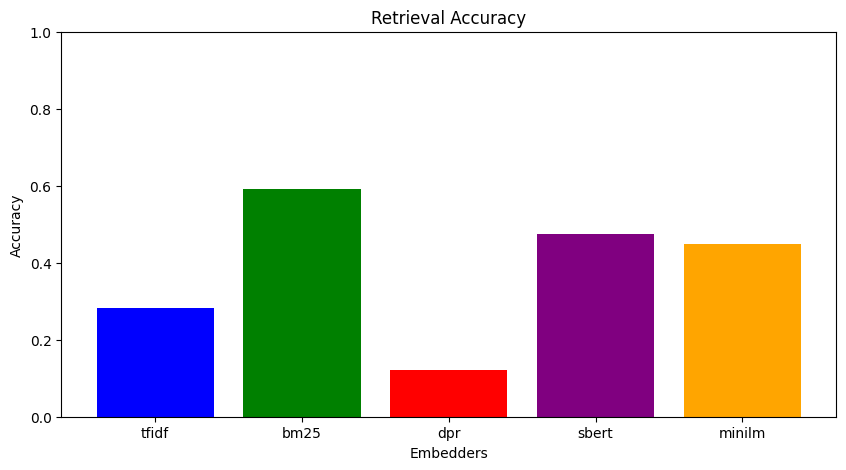

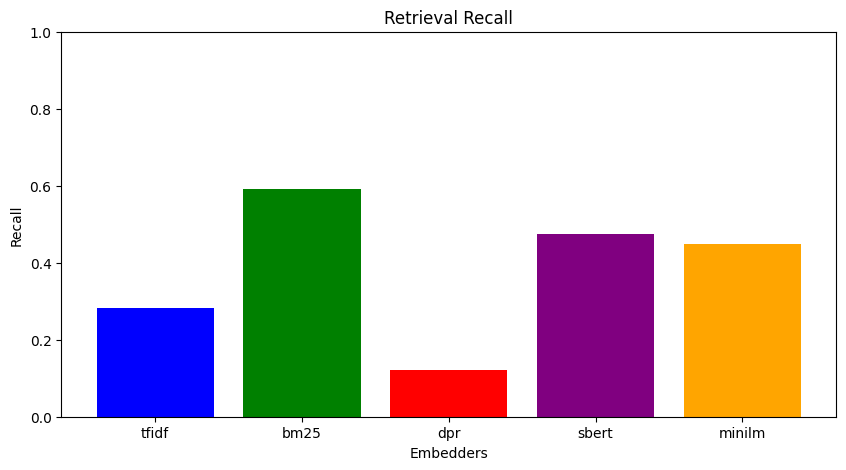

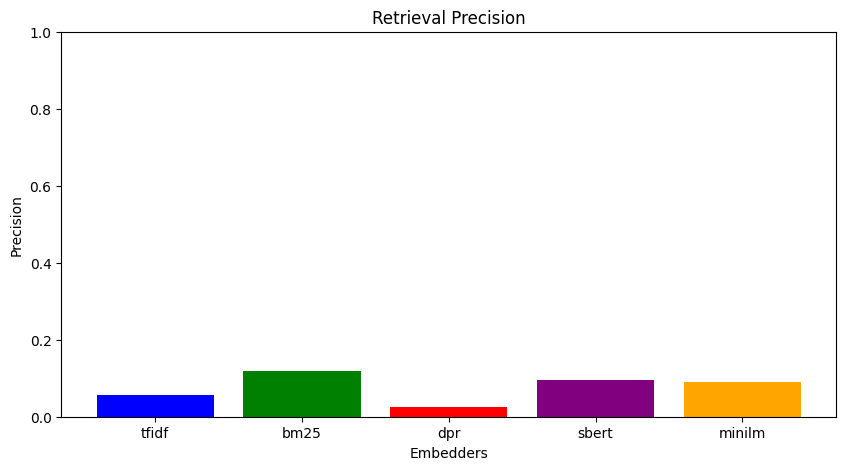

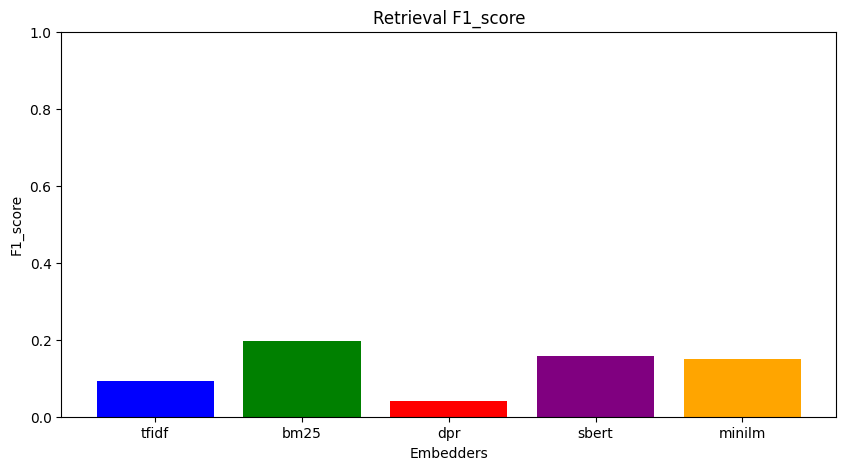

In [61]:
def plot_metrics(results):
    metrics = ['accuracy', 'recall', 'precision', 'f1_score']
    embedder_names = ['tfidf', 'bm25', 'dpr', 'sbert', 'minilm']
    
    for metric in metrics:
        values = [results[embedder][metric] for embedder in results]
        plt.figure(figsize=(10, 5))
        plt.bar(embedder_names, values, color=['blue', 'green', 'red', 'purple', 'orange'])
        plt.xlabel('Embedders')
        plt.ylabel(metric.capitalize())
        plt.title(f'Retrieval {metric.capitalize()}')
        plt.ylim(0, 1)
        plt.show()

        
plot_metrics(results)